In [1]:


    import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
import itertools
from rake_nltk import Rake
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('movies.csv')
df.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.9,171,NaN,NaN,NaN,NaN,4.0,2.0
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0
3,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2019,NaN,NaN,NaN,NaN,28.0,14.0
4,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...","From the Manger to the Cross; or, Jesus of Naz...",1912,1913,"Biography, Drama",60,USA,English,Sidney Olcott,Gene Gauntier,Kalem Company,"R. Henderson Bland, Percy Dyer, Gene Gauntier,...","An account of the life of Jesus Christ, based ...",5.7,438,NaN,NaN,NaN,NaN,12.0,5.0


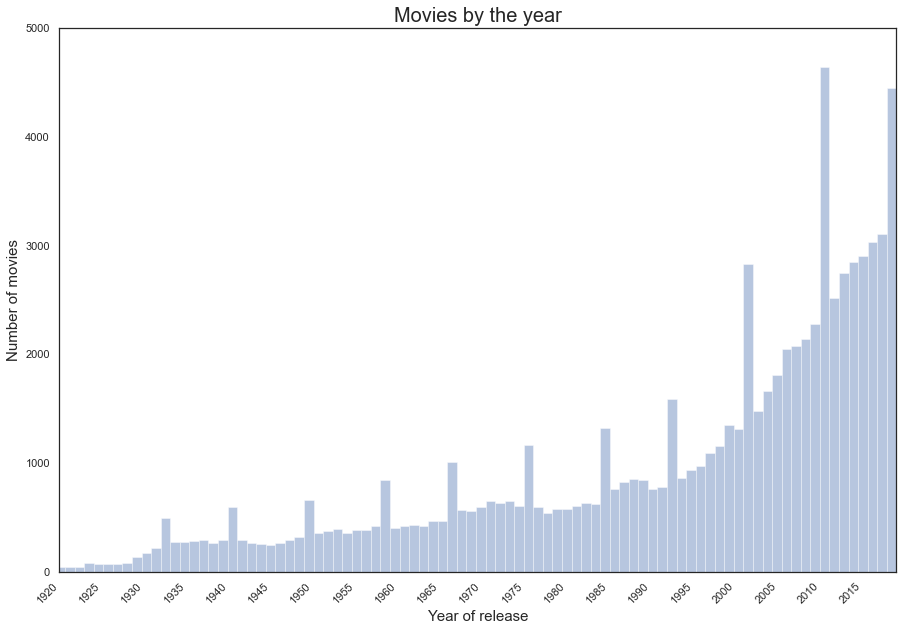

In [3]:
df = df[df.date_published.notnull()]
df['date_published'] = pd.to_datetime(df['date_published'])

sns.set(style="white")

plt.figure(figsize=(15,10))
plt.title('Movies by the year', size=20)
sns.distplot(df.year, bins=100, kde=False)
plt.ylabel('Number of movies', size=15)
plt.xlabel('Year of release',size=15)
plt.axis([1920, 2019, 0, 5000])
plt.xticks(np.arange(1920, 2019, step=5),rotation=45, ha='right')
plt.show()

Text(0.5, 1.0, 'Distribution of Studio names')

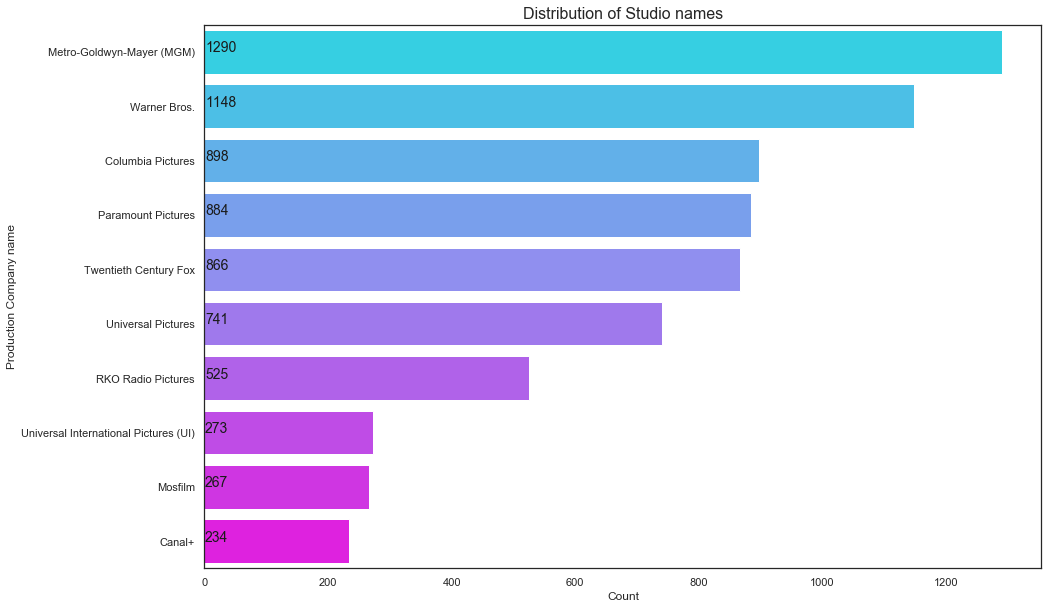

In [4]:
a = plt.cm.cool
plt.figure(figsize=(15,10))
count = df['production_company'].value_counts()[:10]
sns.barplot(count.values, count.index, palette=[a(0.1),a(0.2),a(0.3),a(0.4),a(0.5),a(0.6),a(0.7),a(0.8),a(0.9),a(0.99)])
for i, v in enumerate(count.values):
    plt.text(0.8,i,v,color='k',fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Production Company name', fontsize=12)
plt.title("Distribution of Studio names", fontsize=16)

Text(0.5, 1.0, 'Distribution of Genres')

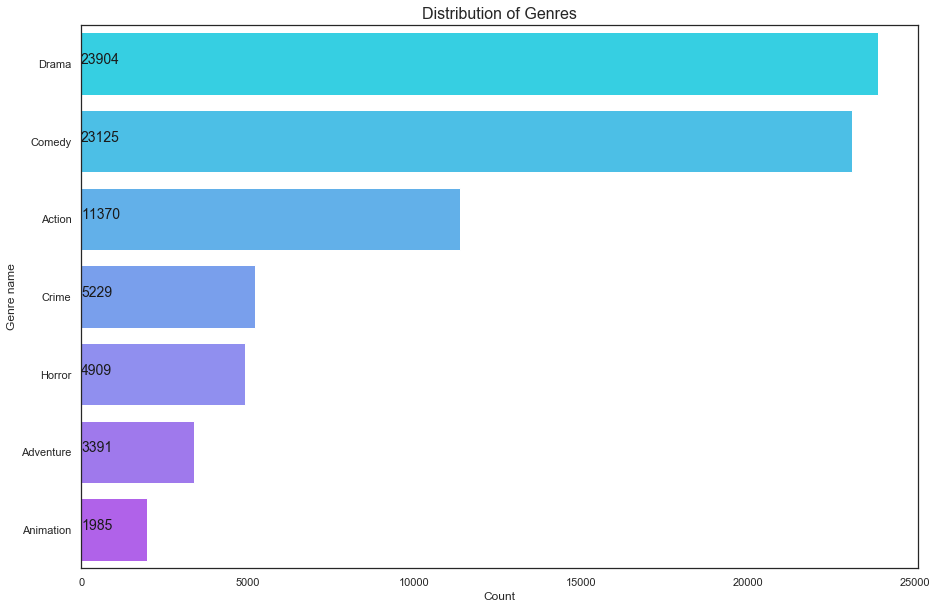

In [5]:
df['first_genre'] = df['genre'].str.split(',').str[0]

a = plt.cm.cool

plt.figure(figsize=(15,10))
count = df['first_genre'].value_counts()[:7]
sns.barplot(count.values, count.index, palette=[a(0.1),a(0.2),a(0.3),a(0.4),a(0.5),a(0.6),a(0.7)])
for i, v in enumerate(count.values):
    plt.text(0.8,i,v,color='k',fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Genre name', fontsize=12)
plt.title("Distribution of Genres", fontsize=16)

In [6]:
df.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics', 'first_genre'],
      dtype='object')

In [7]:
# Recommender
df1 = df[['title','director','actors','genre','description']]
rec_df = df1.sample(frac= 0.7)

In [8]:
rec_df.shape

(56891, 5)

In [9]:
rec_df.isnull().sum()

title             0
director         48
actors           42
genre             0
description    1670
dtype: int64

In [10]:
rec_df['director']=rec_df['director'].fillna(' ')
rec_df['director']=rec_df['director'].astype('str')
rec_df['actors']=rec_df['actors'].fillna(' ')
rec_df['actors']=rec_df['actors'].astype('str')

In [11]:
rec_df = rec_df[rec_df['description'].notna()]

In [12]:
rec_df['important_words'] = ""

for index, word in rec_df.iterrows():
    content = word['description']
    r = Rake()
    r.extract_keywords_from_text(content)
    important_words_score = r.get_word_degrees()
    word['important_words'] = list(important_words_score.keys())
rec_df.drop(columns = ['description'],inplace = True)

In [13]:
rec_df.head()

,title,director,actors,genre,important_words
15379,Dark Star,John Carpenter,"Brian Narelle, Cal Kuniholm, Dre Pahich, Dan O...","Comedy, Sci-Fi","[solitary, mission, find, things, beginning, s..."
79232,Hamid,Aijaz Khan,"Talha Arshad Reshi, Vikas Kumar, Rasika Dugal,...",Drama,"[decides, dialing, talk, answered, god, allah,..."
38367,Miel para Oshún,Humberto Solás,"Jorge Perugorría, Isabel Santos, Mario Limonta...",Comedy,"[father, dies, cuba, cuban, man, island, ..., ..."
23556,The Unholy,Camilo Vila,"Ruben Rabasa, Nicole Fortier, Peter Frechette,...",Horror,"[priest, battles, demon, act, kills, sinners, ..."
69240,Welcome to Happiness,Oliver Thompson,"Kyle Gallner, Olivia Thirlby, Nick Offerman, K...","Comedy, Drama, Fantasy","[past, woody, life, erase, mistakes, closet, f..."


In [14]:
rec_df['director'] = rec_df['director'].map(lambda d: d.split(' '))
rec_df['actors'] = rec_df['actors'].map(lambda c: c.split(',')[:3])

for index, name in rec_df.iterrows():
    name['actors'] = [c.lower().replace(' ','') for c in name['actors']]
    name['director'] = ''.join(name['director']).lower()
    
rec_df['genre'] = rec_df['genre'].map(lambda l: l.lower().split(','))
rec_df.set_index('title', inplace = True)

In [15]:
rec_df.head()

,director,actors,genre,important_words
title,,,,
Dark Star,johncarpenter,"[briannarelle, calkuniholm, drepahich]","[comedy, sci-fi]","[solitary, mission, find, things, beginning, s..."
Hamid,aijazkhan,"[talhaarshadreshi, vikaskumar, rasikadugal]",[drama],"[decides, dialing, talk, answered, god, allah,..."
Miel para Oshún,humbertosolás,"[jorgeperugorría, isabelsantos, mariolimonta]",[comedy],"[father, dies, cuba, cuban, man, island, ..., ..."
The Unholy,camilovila,"[rubenrabasa, nicolefortier, peterfrechette]",[horror],"[priest, battles, demon, act, kills, sinners, ..."
Welcome to Happiness,oliverthompson,"[kylegallner, oliviathirlby, nickofferman]","[comedy, drama, fantasy]","[past, woody, life, erase, mistakes, closet, f..."


In [16]:
rec_df['bagged_words'] = ''
columns = rec_df.columns
for index, row in rec_df.iterrows():
    words = ''
    for col in columns:
        if col != 'director':
            words = words + ' '.join(row[col])+ ' '
        else:
            words = words + row[col]+ ' '
    row['bagged_words'] = words
    
rec_df.drop(columns = [col for col in rec_df.columns if col!= 'bagged_words'], inplace = True)

In [17]:
rec_df.dtypes

bagged_words    object
dtype: object

In [18]:
# Modeling
c = CountVectorizer()
c_matrix = c.fit_transform(rec_df['bagged_words'])

In [19]:
indices = pd.Series(rec_df.index)
indices[:5]

0               Dark Star
1                   Hamid
2         Miel para Oshún
3              The Unholy
4    Welcome to Happiness
Name: title, dtype: object

In [20]:
rec_df.dtypes

bagged_words    object
dtype: object

In [ ]:
# Cosine similarity matrix
cosine_matrix = cosine_similarity(c_matrix,c_matrix)
cosine_matrix

In [ ]:
def recommendations(title, cosine_matrix = cosine_matrix):
    
    recommended_movies = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_matrix[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(rec_df.index)[i])
        
    return recommended_movies

In [ ]:
#recommendations("Sex Education")